## Seasonal-Trend decomposition using LOESS (STL)
 
`STL` to decompose a time series into three components: `trend`, `season(al)` and `residual`. 

STL uses `LOESS` (locally estimated scatterplot smoothing) to extract smooths estimates of the three components. 

**The key inputs into STL are:**

* `season` - The length of the seasonal smoother. `Must be odd.`

* `trend` - The length of the trend smoother, `usually around 150% of season`. `Must be odd and larger than season`.

* `low_pass` - The length of the low-pass estimation window, `usually the smallest odd number larger than the periodicity of the data`.

In [54]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sktime.utils.plotting import plot_series

from statsmodels.nonparametric._smoothers_lowess import lowess
from statsmodels.tsa.seasonal import STL

## Import the Air passengers data

In [55]:
df = pd.read_csv('../../Datasets/example_air_passengers.csv', parse_dates=['ds'], index_col=['ds'])
df.head()

,y
ds,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


## Air passenger data 
* Data has Monthly granularity
* Yearly seasonaltiy, sp=12


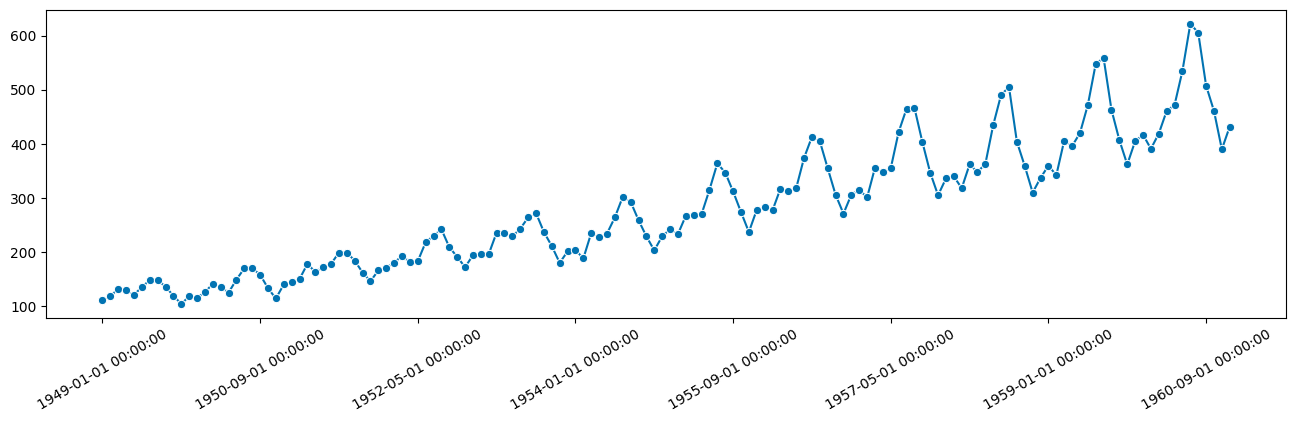

In [56]:
plot_series(df);
plt.xticks(rotation=30);

## STL parameters

### `seasonal`:
* Determines the window size for LOESS used when smoothing the seasonal component (i.e, the cycle-subseries). 
 
* The cycle-subseries is the time series formed by the sequence of values from the same period in the seasonal cycle (e.g., the sequence of all the values which occured on January over each year, the sequence of all the values which occured on February over each year, etc.). 

* This parameter determines how smooth the seasonal component is for the same period (e.g., every January) across multiple seasonal cycles (e.g, multiple years).

### `period`: 
* The periodicity of the seasonal component (for yearly seasonality and monthly data, this would be 12 because the seasonal pattern repeats every 12 periods). 
* This variable is used to determine the cycle-subseries and also in the low pass filtering step of the algorithm.

### `robust`: 
* A flag to use robustness weights during regression in LOESS. This ensures robustness to outliers.



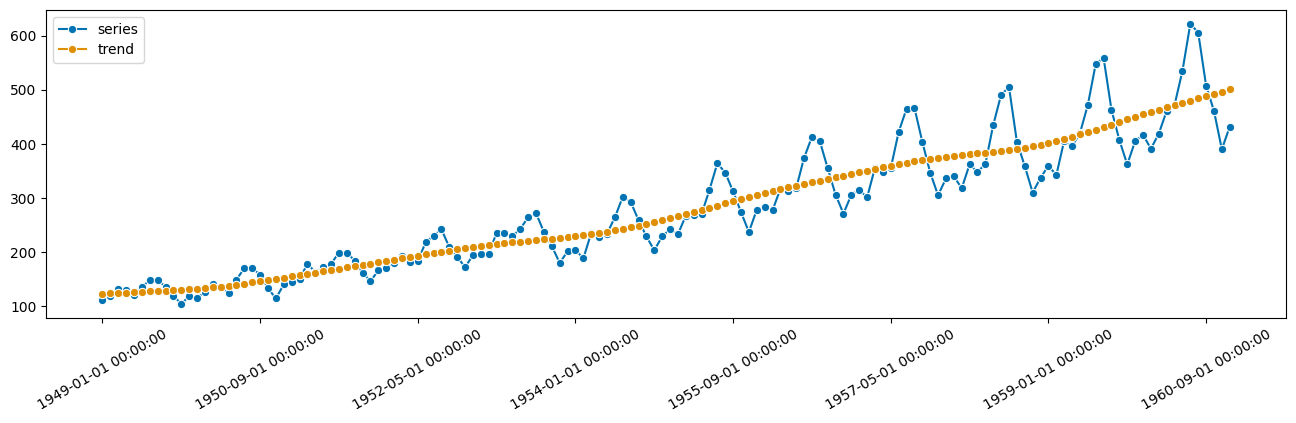

In [57]:
stl = STL(
    endog=df['y'],
    period=12, # the seasonal periodicity
    seasonal=7, # the window size for smoothing cyclic sub-series (the seasonal component)
    robust=True #robust to outliers
).fit()

plot_series(df, stl.trend, labels=['series', 'trend']);
plt.xticks(rotation=30);

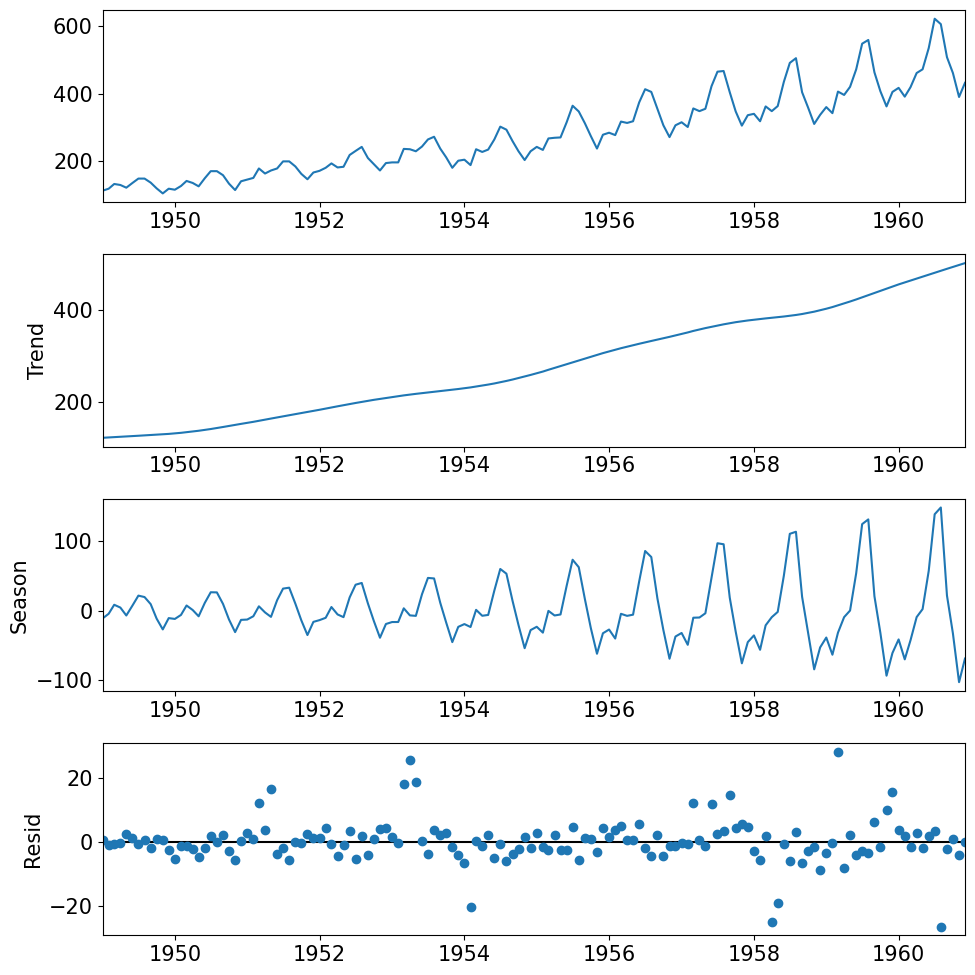

In [58]:
# Plot the full decomposition
plt.rc("figure", figsize=(10, 10))
plt.rc("font", size=15)
stl.plot();

The main parameters of STL come about from the repeated use of LOESS to smooth various time series in the algorithm. 

LOESS is used in the following areas in the STL aglorithm, we specify the corresponding LOESS parameters:

1) Smoothing the seasonal component (i.e., the seasonal cycle-subseries)
- `seasonal`: LOESS window size
- `seasonal_deg`: Degree of the polynomial to use when doing regression in LOESS. 
- `seasonal_jump`: Reduces computational cost of applying LOESS by not evaluating LOESS at every data point but instead evaluating it at a given point and then skipping the number of points specified by this parameter before evaluating LOESS again at a new data point. The intermediate skipped points are evaluated using a linear interpolation instead.

2) Low pass filtering the cycle-subseries
- `low_pass`: LOESS window size
- `low_pass_deg`: Degree of the polynomial to use when doing regression in LOESS. 
- `low_pass_jump`: Reduces computational cost of applying LOESS by not evaluating LOESS at every data point but instead evaluating it at a given point and then skipping the number of points specified by this parameter before evaluating LOESS again at a new data point. The intermediate skipped points are evaluated using a linear interpolation instead.

3) Smoothing the trend component after de-seasonalising the data
- `trend`: LOESS window size
- `trend_deg`: Degree of the polynomial to use when doing regression in LOESS. 
- `trend_jump`: Reduces computational cost of applying LOESS by not evaluating LOESS at every data point but instead evaluating it at a given point and then skipping the number of points specified by this parameter before evaluating LOESS again at a new data point. The intermediate skipped points are evaluated using a linear interpolation instead.

## Load the Retail-sales data

In [59]:
df = pd.read_csv('../../Datasets/example_retail_sales.csv', parse_dates=['ds'], index_col=['ds'])

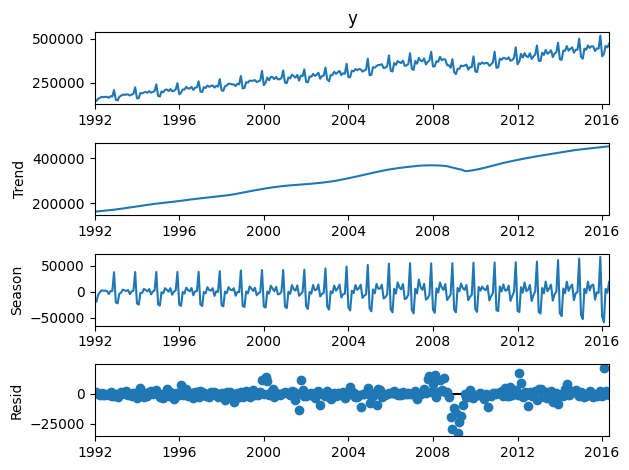

In [90]:
stl = STL(
    endog=df['y'], period=12, seasonal=7, robust=True
).fit()

stl.plot();

In [61]:
df['trend'] = stl.trend
df['seasonal'] = stl.seasonal
df.head()

,y,trend,seasonal
ds,,,
1992-01-01,146376,163507.268049,-18105.934264
1992-02-01,147079,164270.425274,-19220.032341
1992-03-01,159336,165042.317260,-5396.563294
1992-04-01,163669,165822.245976,-885.576431
1992-05-01,170068,166609.427740,2929.056385


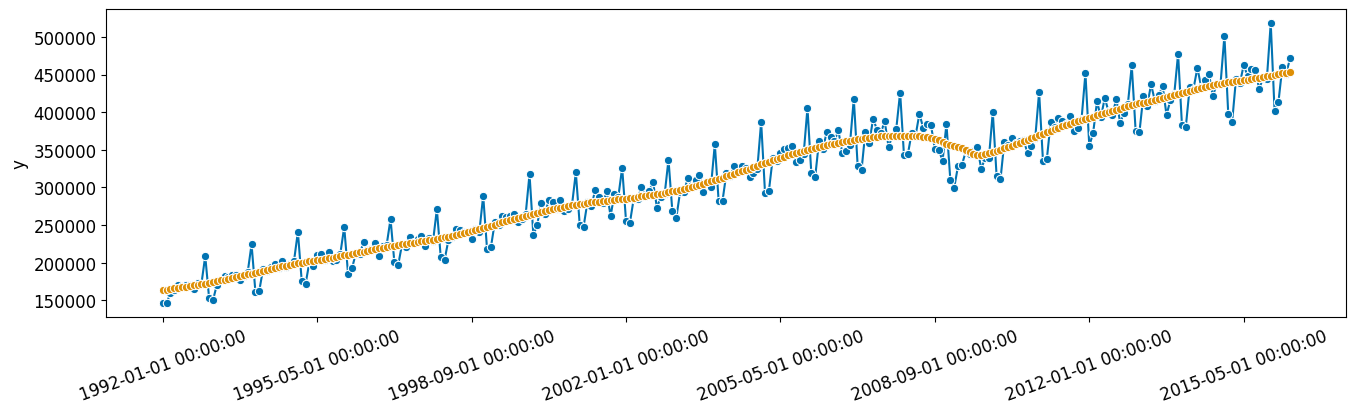

In [62]:
plt.rc('font', size=12)
plot_series(df['y'], df['trend'])
plt.xticks(rotation=20);

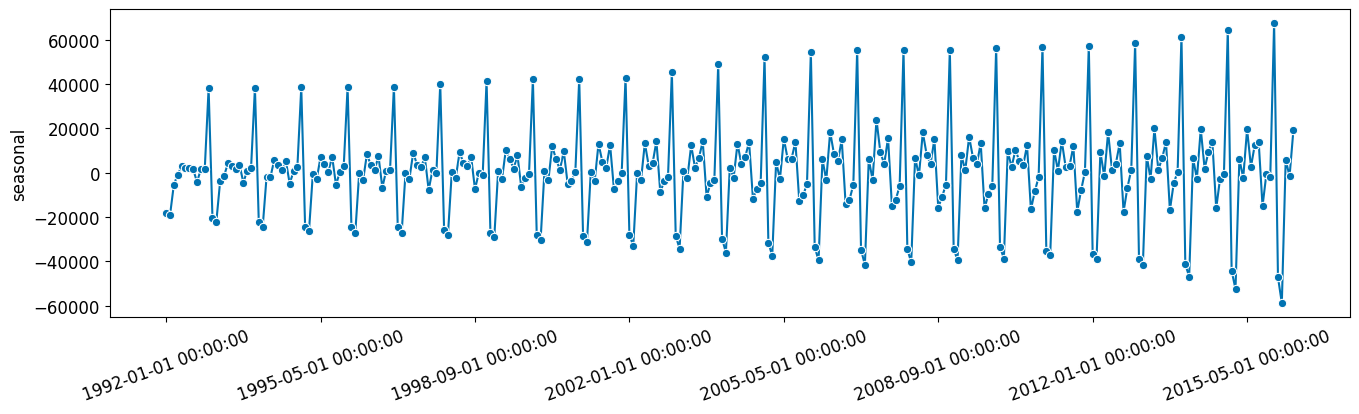

In [63]:
plot_series(df['seasonal']);
plt.xticks(rotation=20);

## Cycle-sub-series

The cycle-subseries is the time series formed by the sequence of values from the same period in the seasonal cycle 
*  the sequence of all the values which occured on January over each year,
*  the sequence of all the values which occured on February over each year, etc.). 

STL make use of cycle-sub-series to obtain a smooth seasonal component that can vary with time

With the parameters we used in the previous section the magnitude of the seasonal component can change over time. 

This means, for example, the magnitude of the January component of the seasonality can vary with time. 

Depending on the context this may be a desired property or not. This behaviour arises from the smooth curve that is fitted to the cycle sub-series.


In [64]:
df['y_detrended'] = df['y']-df['trend']

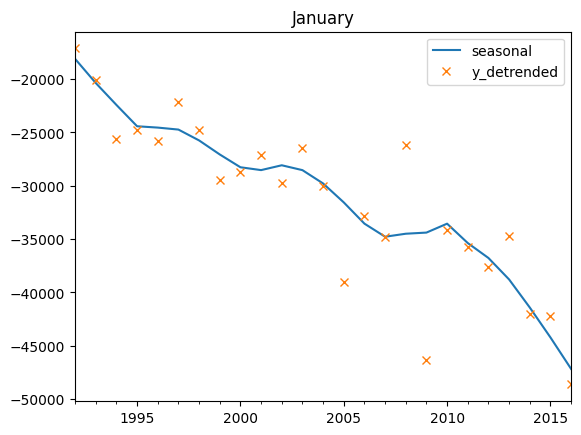

In [68]:
plt.rcdefaults()
ax = df[df.index.month == 1].plot(y='seasonal')
df[df.index.month == 1].plot(y='y_detrended', ls='', marker='x', ax=ax)
plt.title('January');

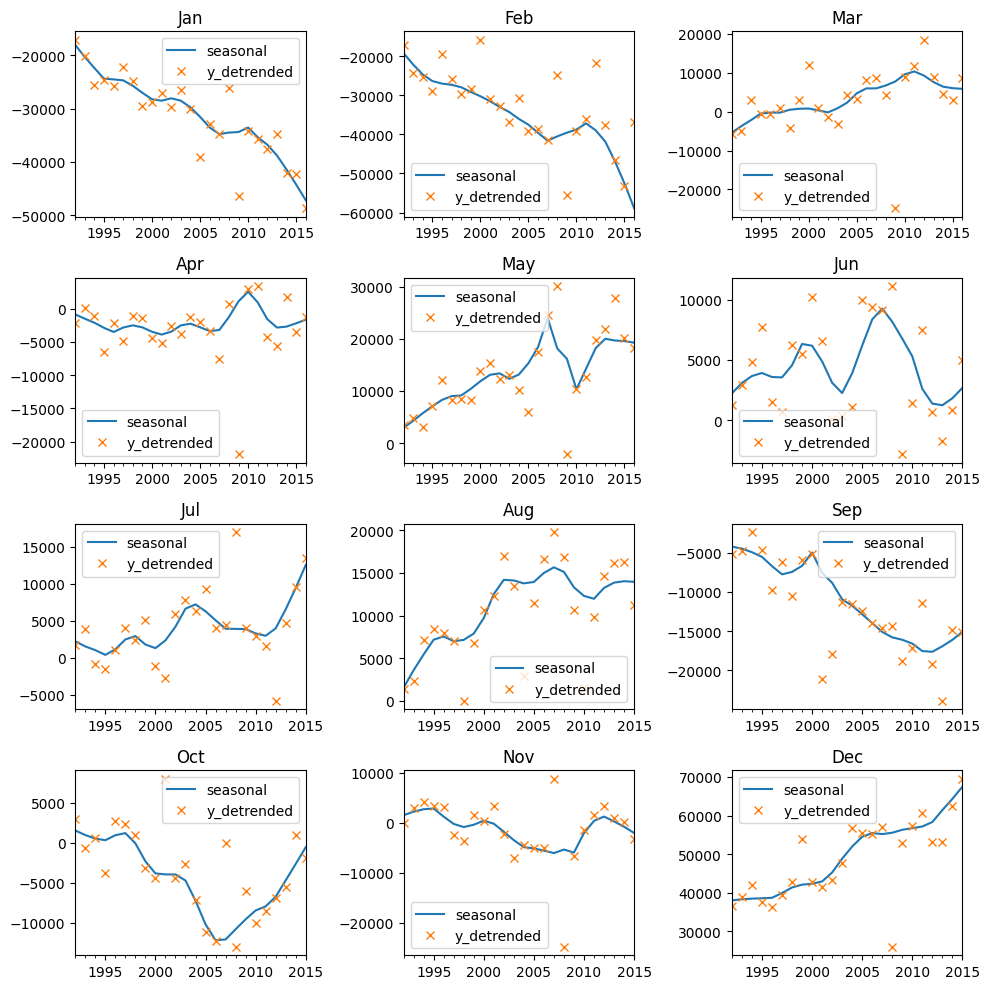

In [77]:
monthDict={1:'Jan', 2:'Feb', 3:'Mar', 4:'Apr', 5:'May', 6:'Jun',
           7:'Jul', 8:'Aug', 9:'Sep', 10:'Oct', 11:'Nov', 12:'Dec'}

fig, ax = plt.subplots(nrows=4, ncols=3, figsize=(10,10))


for i, frame in enumerate(ax.ravel()):
    df[df.index.month == i+1].plot(y='seasonal', ax=frame)
    df[df.index.month == i+1].plot(y='y_detrended', ls='', marker='x', ax=frame)
    frame.set(title=f'{monthDict[i+1]}')

plt.tight_layout()

* We can see the smooth curve that STL has fit to each cycle sub-series. 
* This smooth fit for each cycle sub-series is obtained through a LOESS fit.

#### Hence, if we wanted a seasonal component with a constant magnitude over time, then we would want each cycle sub-series to be a constant (i.e., a flat line). 

* This would mean, for example, the January component of the seasonality has a fixed magnitude over time.
* This can be achieved by increasing the window of the LOESS smoothing for the seasonal component to encompass a large fraction of the data 
* i.e., set `seasonal` to a value comparable or larger than the length of a cycle sub-series. 

* However, this would still fit a straight line through each cycle-subseries, which is not what we want. We can set the `degree of the polynomial fit of LOESS to zero`
* This means that during LOESS rather than taking a linear regression of a subset of data to fit a line it instead just takes the simple average of the subset of data to fit a flat line. This can be achieved by setting `seasonal_deg` to 0.




In [82]:
stl = STL(
    endog=df['y'],
    period=12,
    seasonal=101, #Determines the window size for LOESS used when smoothing the seasonal component
    robust=True,
    seasonal_deg=0 #Fit a constant value (i.e., flat line)
).fit()


constant_periodicity = pd.DataFrame(
    data={
        'y':df['y'],
        'trend':stl.trend,
        'seasonal-fixed':stl.seasonal,
        'y_detrended': df['y']-stl.trend
    }
)

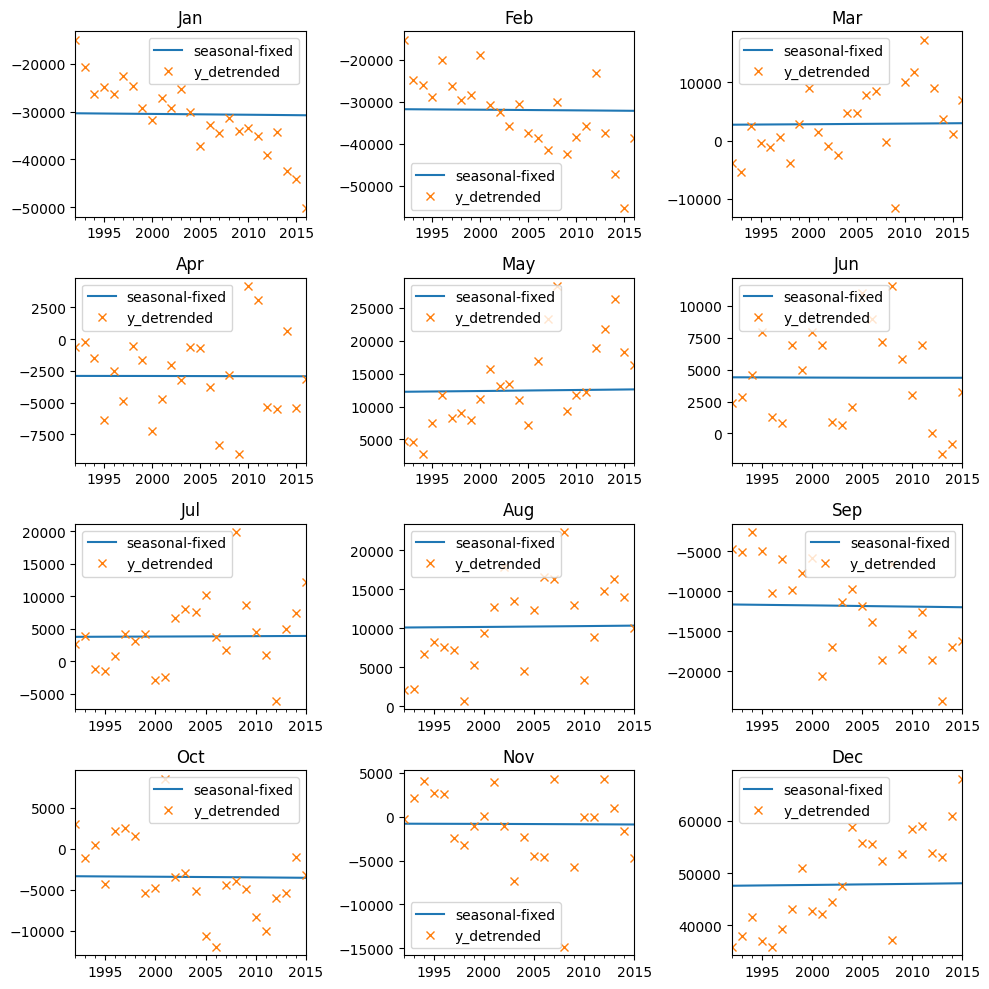

In [83]:
fig, ax = plt.subplots(nrows=4, ncols=3, figsize=(10,10))


for i, frame in enumerate(ax.ravel()):
    constant_periodicity[constant_periodicity.index.month == i+1].plot(y='seasonal-fixed', ax=frame)
    constant_periodicity[constant_periodicity.index.month == i+1].plot(y='y_detrended', ls='', marker='x', ax=frame)
    frame.set(title=f'{monthDict[i+1]}')

plt.tight_layout()

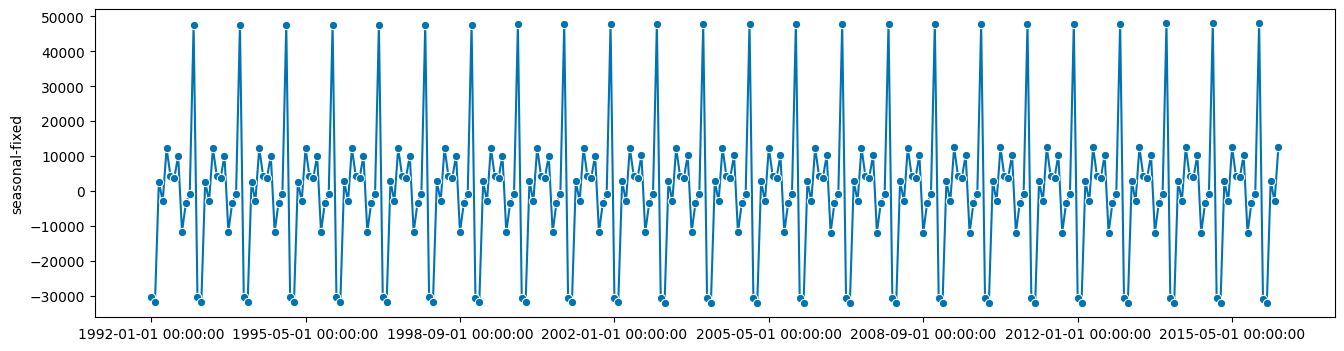

In [85]:
plot_series(constant_periodicity['seasonal-fixed']);

Note: The larger residuals seen in the residual plot indicate a poorer fit to the data. 

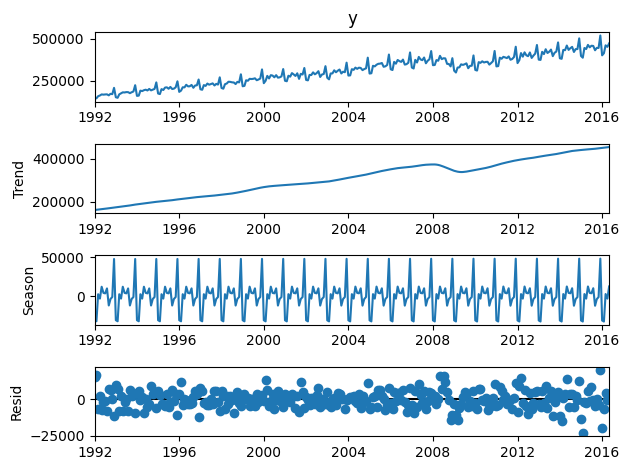

In [87]:
stl.plot();